# <a id='toc1_'></a>[Assignment 4: Formative Task](#toc0_)

**Spatial Data Analytics (GEOM90006)**

**Semester 1, 2025**  
**Date:** 27 May, 2025  

**Group:** 26

---

**Table of contents**<a id='toc0_'></a>    
- [Assignment 4: Formative Task](#toc1_)    
  - [Load Data](#toc1_1_)    
    - [Australia Shape File](#toc1_1_1_)    
    - [Census 2016 Data](#toc1_1_2_)    
    - [Air Quality Data](#toc1_1_3_)    
  - [Data Pre-Processing](#toc1_2_)    
  - [Exploratory Spatial Data Analysis](#toc1_3_)    
    - [Interpretation](#toc1_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

In [ ]:
# Importing Required Packages

# --- Data Analysis ---
import pandas as pd
import numpy as np
import math

# --- Geo ---
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.patches import FancyArrowPatch

# --- Visualization ---
import matplotlib.pyplot as plt


## <a id='toc1_1_'></a>[Load Data](#toc0_)

### <a id='toc1_1_1_'></a>[Australia Shape File](#toc0_)

In [2]:
sa2 = gpd.read_file('Data/SA2_2016_AUST.shp')

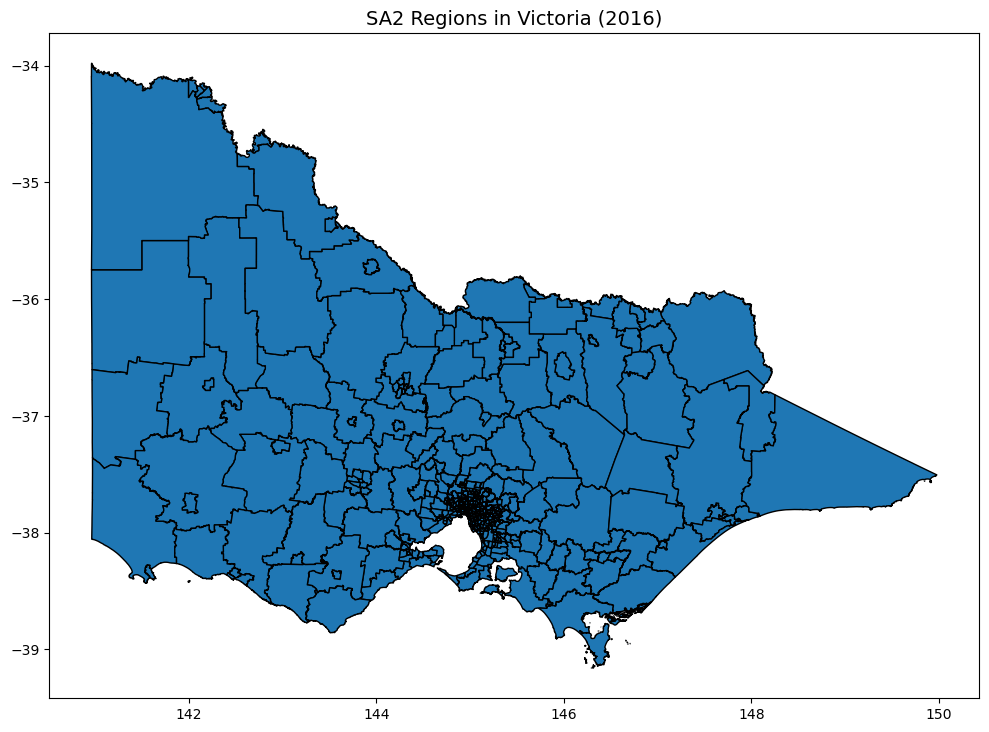

In [3]:
vicSA2 = sa2[sa2['STE_NAME16'] == 'Victoria']

vicSA2.plot(figsize=(12, 12), edgecolor='black')
plt.title('SA2 Regions in Victoria (2016)', fontsize=14)
plt.show()

In [ ]:
targetSubs = [
    'Alphington - Fairfield', 'West Footscray - Tottenham', 'Churchill', 'Moe - Newborough',
    'Morwell', 'Traralgon'
]
subsSA2 = vicSA2[vicSA2['SA2_NAME16'].isin(targetSubs)].copy()

subsSA2['SA2_MAIN16'] = subsSA2['SA2_MAIN16'].astype(int)
subsSA2['AREASQKM16'] = subsSA2['AREASQKM16'].astype(float)

for col in ['SA2_NAME16','SA3_NAME16','SA4_NAME16','GCC_NAME16']:
    subsSA2[col] = subsSA2[col].astype('category')

suburb = subsSA2.loc[:, [
    "SA2_MAIN16","SA2_NAME16","SA3_NAME16",
    "SA4_NAME16","GCC_NAME16","AREASQKM16","geometry"
]]

### <a id='toc1_1_2_'></a>[Census 2016 Data](#toc0_)

In [ ]:
popDF = pd.read_csv("Data/2016Census_G01_VIC_SA2.csv")

population = popDF[["SA2_MAINCODE_2016", "Tot_P_M","Tot_P_F", "Tot_P_P"]]

### <a id='toc1_1_3_'></a>[Air Quality Data](#toc0_)

In [6]:
airQ = pd.read_excel("Data/All_sites_air_quality_hourly_avg_AIR.xlsx", sheet_name="Data")
print("Columns in air quality file:", airQ.columns.tolist())

Columns in air quality file: ['sample_point_id', 'sp_name', 'latitude', 'longitude', 'sample_datetime', 'time_basis_id', 'param_id', 'param_name', 'value', 'param_std_unit_of_measure', 'param_short_name']


In [7]:
airQ['sample_datetime'] = pd.to_datetime(airQ['sample_datetime'])

pm25 = airQ[airQ['param_short_name'] == 'PM2.5']
pm25 = pm25[pm25['sample_datetime'].dt.year == 2016]

meanPM25 = (
    pm25
    .groupby(['sp_name','latitude','longitude'])['value']
    .mean()
    .reset_index()
    .rename(columns={'value':'mean_pm25'})
)

## <a id='toc1_2_'></a>[Data Pre-Processing](#toc0_)

In [8]:
meanPM25['geometry'] = meanPM25.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
sitesGDF = gpd.GeoDataFrame(meanPM25, crs="EPSG:4283")

sitesGDF = sitesGDF.to_crs(vicSA2.crs)

In [9]:
sitesSA2 = gpd.sjoin(
    sitesGDF,
    vicSA2[['SA2_MAIN16','SA2_NAME16','geometry']],
    how='left',
    predicate='within'
)

pm25SA2 = (
    sitesSA2
    .dropna(subset=['SA2_MAIN16'])
    .groupby(['SA2_MAIN16','SA2_NAME16'])['mean_pm25']
    .mean()
    .reset_index()
)

pm25SA2['SA2_MAIN16'] = pm25SA2['SA2_MAIN16'].astype(int)

suburb = suburb.merge(
    pm25SA2,
    on=['SA2_MAIN16','SA2_NAME16'],
    how='left'
)

popMap = suburb.merge(
    population.astype({'SA2_MAINCODE_2016': int}),
    how='left',
    left_on="SA2_MAIN16",
    right_on="SA2_MAINCODE_2016"
)

## <a id='toc1_3_'></a>[Exploratory Spatial Data Analysis](#toc0_)

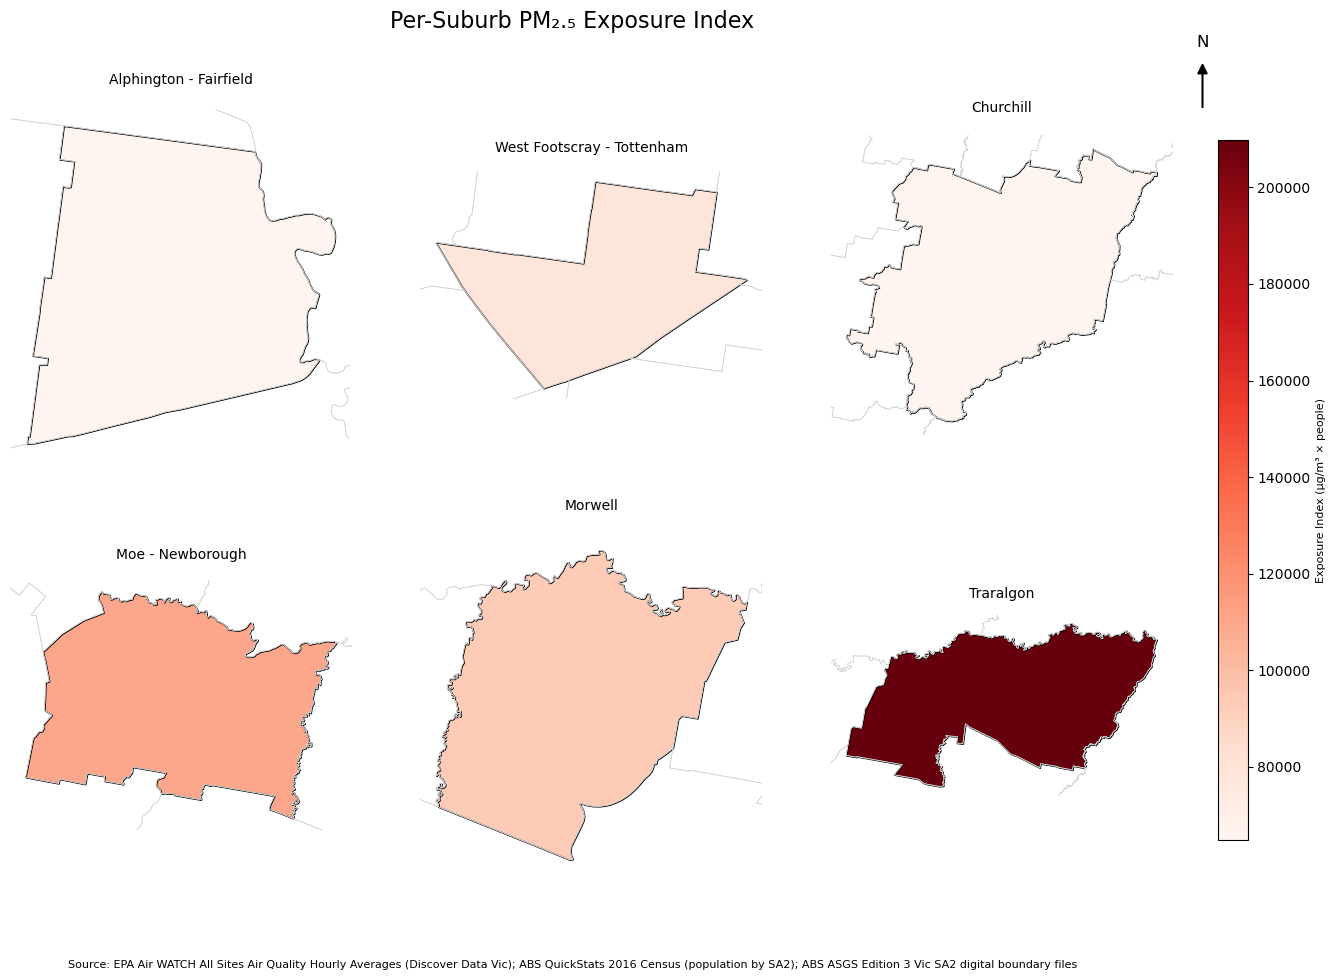

In [10]:
popMap = popMap.to_crs(epsg=7899)
vicSa2 = vicSA2.to_crs(epsg=7899)

popMap['exposure_index'] = popMap['mean_pm25'] * popMap['Tot_P_P']

fig, axes = plt.subplots(
    nrows=math.ceil(len(targetSubs) / 3),
    ncols=3,
    figsize=(15, 10),
    constrained_layout=False
)
axes = axes.flatten()

vMin = popMap['exposure_index'].min()
vMax = popMap['exposure_index'].max()

for i, name in enumerate(targetSubs):
    ax = axes[i]
    rowData = popMap[popMap['SA2_NAME16'] == name]

    minX, minY, maxX, maxY = rowData.total_bounds
    deltaX = (maxX - minX) * 0.05
    deltaY = (maxY - minY) * 0.05

    vicSa2.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
    rowData.plot(
        column='exposure_index',
        ax=ax,
        cmap='Reds',
        vmin=vMin,
        vmax=vMax,
        edgecolor='black',
        linewidth=1,
        legend=False
    )

    ax.set_xlim(minX - deltaX, maxX + deltaX)
    ax.set_ylim(minY - deltaY, maxY + deltaY)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name, fontsize=10, loc='center', x=0.5, y=1.05)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

scalarMap = ScalarMappable(norm=mpl.colors.Normalize(vmin=vMin, vmax=vMax), cmap='Reds')
scalarMap._A = []
colorbarAxes = fig.add_axes([0.93, 0.15, 0.02, 0.7])
colorbar = fig.colorbar(scalarMap, cax=colorbarAxes)
colorbar.set_label('Exposure Index (µg/m³ × people)', fontsize=8)

fig.suptitle("Per-Suburb PM₂.₅ Exposure Index", fontsize=16)

fig.text(
    0.5,
    0.02,
    "Source: EPA Air WATCH All Sites Air Quality Hourly Averages (Discover Data Vic); "
    "ABS QuickStats 2016 Census (population by SA2); ABS ASGS Edition 3 Vic SA2 digital boundary files",
    ha='center',
    va='bottom',
    transform=fig.transFigure,
    fontsize=8
)

arrow = FancyArrowPatch(
    posA=(0.92, 0.88),
    posB=(0.92, 0.93),
    transform=fig.transFigure,
    arrowstyle='-|>',
    mutation_scale=15,
    linewidth=1.5,
    color='black'
)
fig.add_artist(arrow)
fig.text(
    0.92,
    0.94,
    'N',
    ha='center',
    va='bottom',
    transform=fig.transFigure,
    fontsize=12
)

plt.show()

### <a id='toc1_3_1_'></a>[Interpretation](#toc0_)

This map illustrates a PM2.5 Exposure Index across six selected SA2 regions in Victoria, based on 2016 data. The index was computed by multiplying the average PM2.5 concentration (µg/m³) by the population of each SA2, representing the total community exposure rather than concentration alone. Notably, Traralgon shows the highest exposure index, suggesting that even moderate pollution levels in more dense regional areas can result in elevated community health risks. In contrast, smaller areas like Churchill and Footscray display lower exposure indices, either due to lower PM2.5 levels or smaller population sizes. This visualisation provides an important public health perspective by shifting the focus from pollution hotspots to population-weighted impact.

However, due to the limited availability of PM2.5 data, we were unable to get valuable result to verify the hypotheses. For further analysis, we will seek assistance from the tutor to access an alternative dataset with PM2.5 sample points in more than 15 SA2 locations.